In [1]:
import numpy as np
import matplotlib.pyplot as plt, zipfile
import os
from PIL import Image
import xml.etree.ElementTree as ET

In [2]:
image_dir = os.listdir('./all-dogs')
breeds = os.listdir('./annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))


for breed in breeds:
    for dog in os.listdir('./annotation/Annotation/'+breed):
        try: img = Image.open('./all-dogs/'+dog+'.jpg') 
        except: continue           
        tree = ET.parse('./annotation/Annotation/'+breed+'/'+dog)
        root = tree.getroot() # <annotation>
        objects = root.findall('object') # <object>
        for o in objects:
            bndbox = o.find('bndbox') # <bndbox>
            xmin = int(bndbox.find('xmin').text) # <xmin>
            ymin = int(bndbox.find('ymin').text) # <ymin>
            xmax = int(bndbox.find('xmax').text) # <xmax>
            ymax = int(bndbox.find('ymax').text) # <ymax>
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1                

In [3]:
imagesIn=imagesIn[0:idxIn,:,:,:]
imagesIn.shape[0]

22125

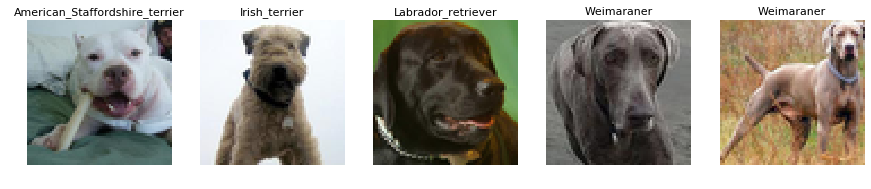

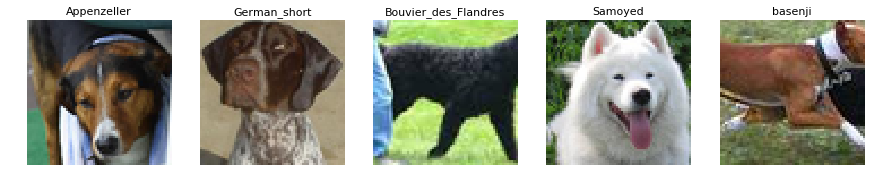

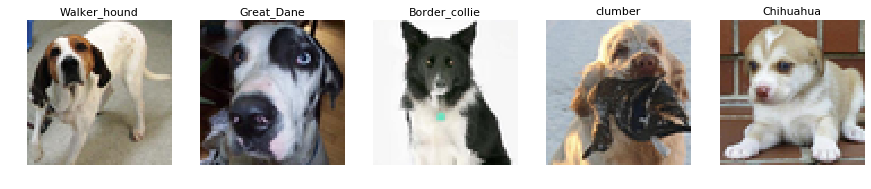

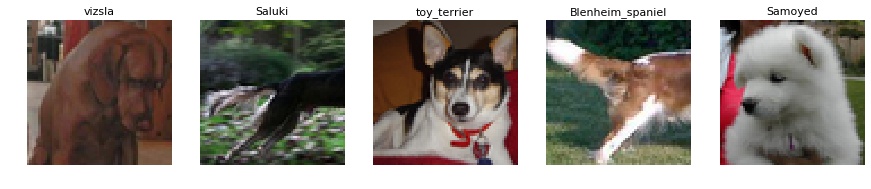

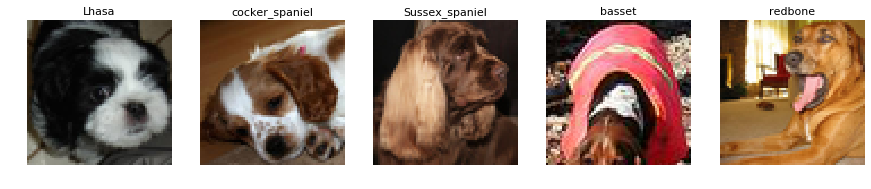

In [4]:
x = np.random.randint(0,idxIn,25)

for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [5]:
from keras.layers import Input, Dense, Reshape, BatchNormalization, Flatten, Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

Generator = Sequential()

Generator.add(Dense(128*16*16,input_dim=100))
Generator.add(LeakyReLU(alpha=0.2))
Generator.add(BatchNormalization(momentum=0.5))
Generator.add(Reshape((16,16,128)))  
Generator.add(UpSampling2D())
Generator.add(Conv2D(128,4,padding='same'))
Generator.add(LeakyReLU(alpha=0.2))
Generator.add(BatchNormalization(momentum=0.5))
Generator.add(UpSampling2D())
Generator.add(Conv2D(64,4,padding='same'))
Generator.add(LeakyReLU(alpha=0.2))
Generator.add(BatchNormalization(momentum=0.5))
Generator.add(Conv2D(3,3,padding='same',activation='tanh'))

Generator.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32768)             131072    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       262272    
_________________________________________________________________
leak

In [6]:
optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

In [7]:
Discriminator = Sequential()

Discriminator.add(Conv2D(32,4,padding='same',input_shape=(64,64,3)))
Discriminator.add(LeakyReLU(alpha=0.2))
Discriminator.add(Conv2D(64,4,padding='same'))
Discriminator.add(LeakyReLU(alpha=0.2))
Discriminator.add(Conv2D(128,4,padding='same'))
Discriminator.add(LeakyReLU(alpha=0.2))

Discriminator.add(Flatten())
Discriminator.add(Dense(1, activation='sigmoid'))
     
Discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
Discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        1568      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
__________

In [8]:
Discriminator.trainable = False
GAN = Sequential()
GAN.add(Generator)
GAN.add(Discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
imagesIn = (imagesIn-127.5)/127.5

Instructions for updating:
Use tf.cast instead.


C:\Users\a2720\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator: d_loss_f: 0.694864, d_loss_r: 1.368121], [ Generator: loss: 0.415966], Training time: 6 s
epoch: 1000, [Discriminator: d_loss_f: 0.655771, d_loss_r: 0.495818], [ Generator: loss: 0.870402], Training time: 335 s
epoch: 2000, [Discriminator: d_loss_f: 0.700365, d_loss_r: 0.563358], [ Generator: loss: 0.839414], Training time: 337 s
epoch: 3000, [Discriminator: d_loss_f: 0.688985, d_loss_r: 0.605586], [ Generator: loss: 0.804317], Training time: 337 s
epoch: 4000, [Discriminator: d_loss_f: 0.648832, d_loss_r: 0.485718], [ Generator: loss: 0.997289], Training time: 337 s
epoch: 5000, [Discriminator: d_loss_f: 0.640030, d_loss_r: 0.672849], [ Generator: loss: 0.905380], Training time: 339 s
epoch: 6000, [Discriminator: d_loss_f: 0.510698, d_loss_r: 0.508062], [ Generator: loss: 1.034998], Training time: 373 s
epoch: 7000, [Discriminator: d_loss_f: 0.513582, d_loss_r: 0.677990], [ Generator: loss: 1.046725], Training time: 349 s
epoch: 8000, [Discriminator: d_loss_f

C:\Users\a2720\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch: 21000, [Discriminator: d_loss_f: 0.341093, d_loss_r: 0.498924], [ Generator: loss: 1.309969], Training time: 860 s
epoch: 22000, [Discriminator: d_loss_f: 0.433777, d_loss_r: 0.332273], [ Generator: loss: 1.838900], Training time: 881 s
epoch: 23000, [Discriminator: d_loss_f: 0.339599, d_loss_r: 0.635230], [ Generator: loss: 1.037358], Training time: 856 s
epoch: 24000, [Discriminator: d_loss_f: 0.250781, d_loss_r: 0.249125], [ Generator: loss: 2.453492], Training time: 844 s
epoch: 25000, [Discriminator: d_loss_f: 0.266810, d_loss_r: 0.281882], [ Generator: loss: 1.697569], Training time: 846 s
epoch: 26000, [Discriminator: d_loss_f: 0.329721, d_loss_r: 0.449697], [ Generator: loss: 1.923878], Training time: 847 s
epoch: 27000, [Discriminator: d_loss_f: 0.377330, d_loss_r: 0.420732], [ Generator: loss: 1.645431], Training time: 845 s
epoch: 28000, [Discriminator: d_loss_f: 0.223063, d_loss_r: 0.076606], [ Generator: loss: 2.281277], Training time: 847 s
epoch: 29000, [Discrimin

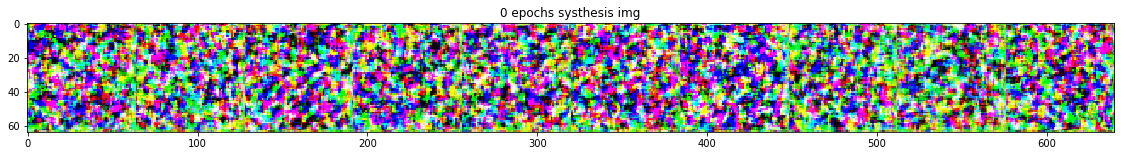

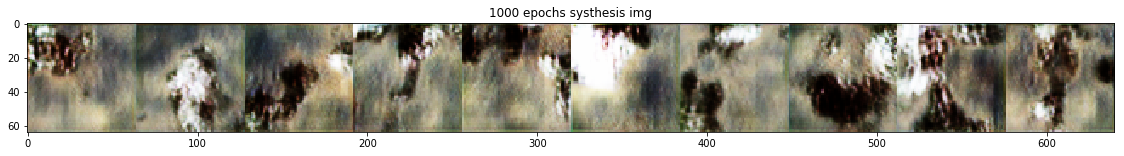

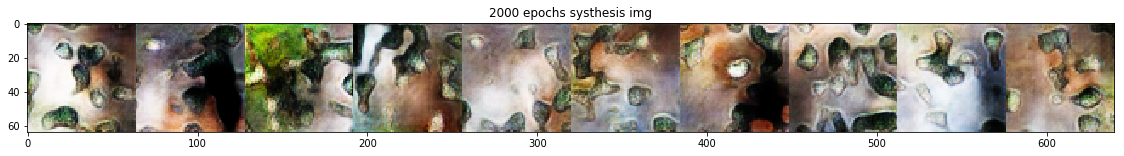

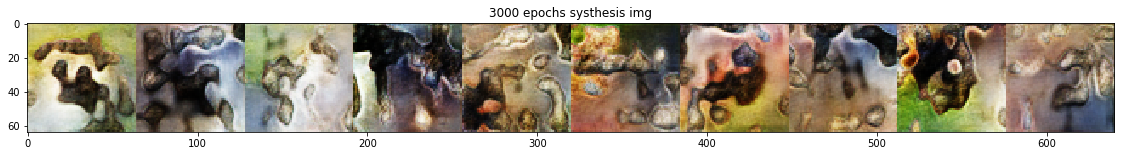

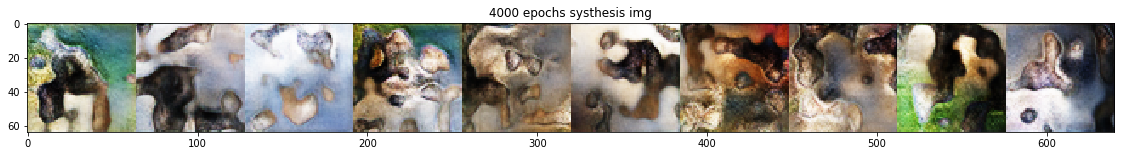

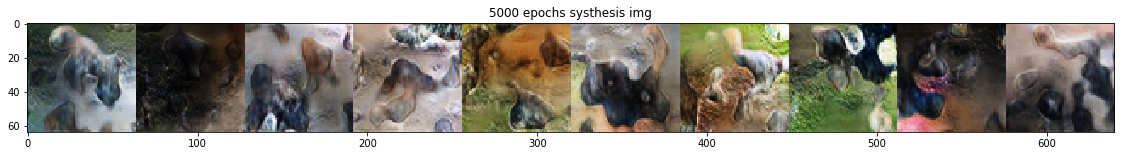

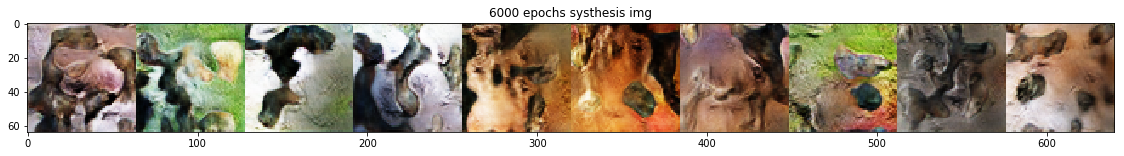

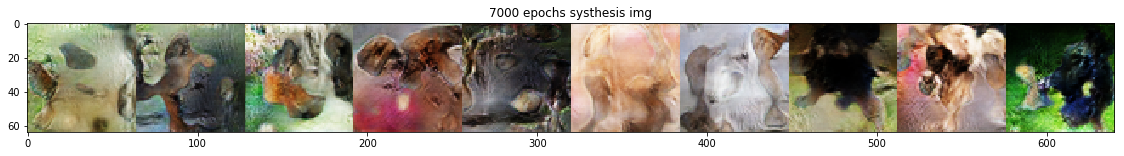

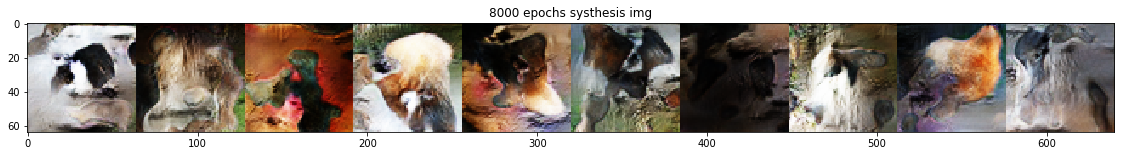

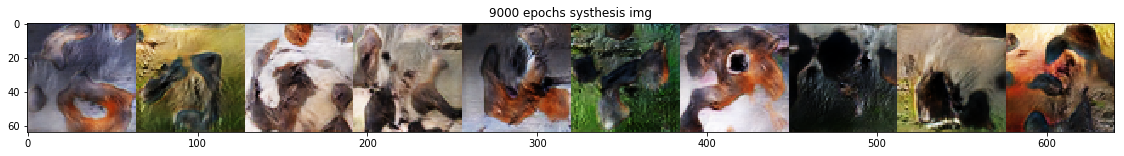

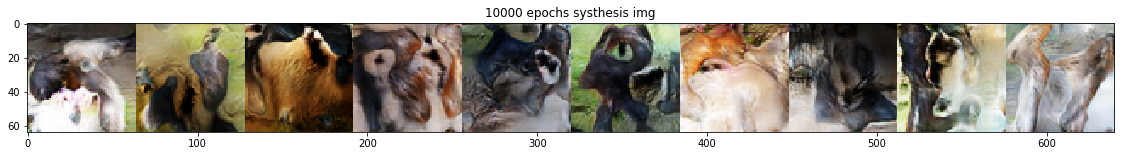

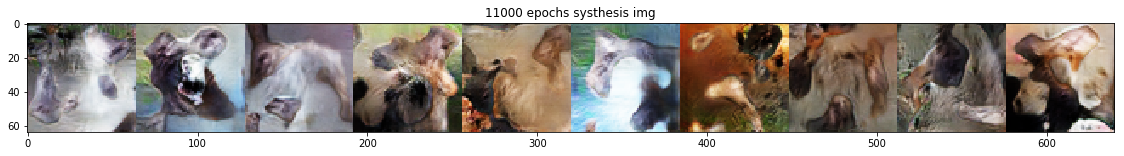

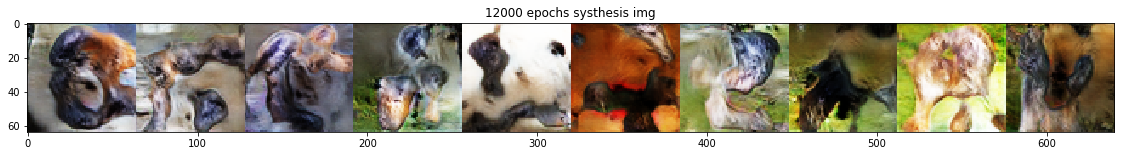

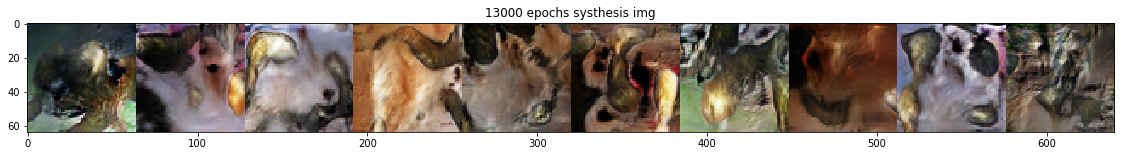

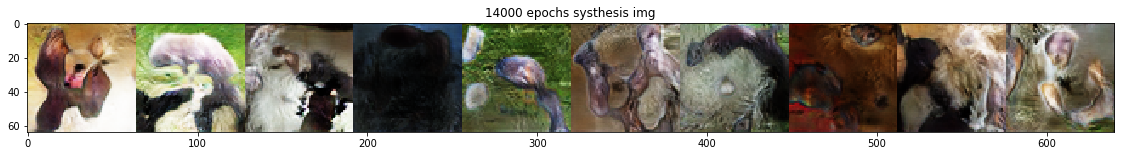

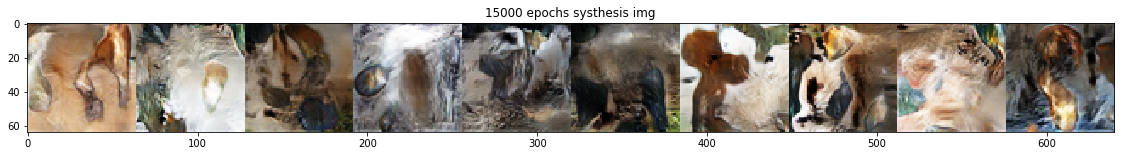

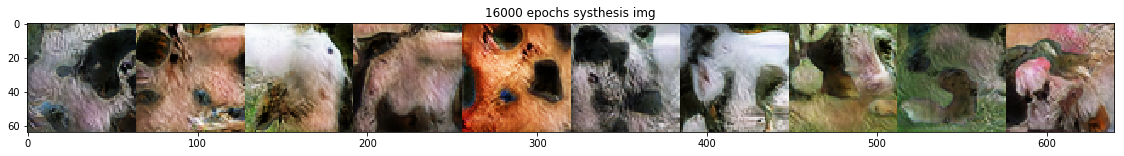

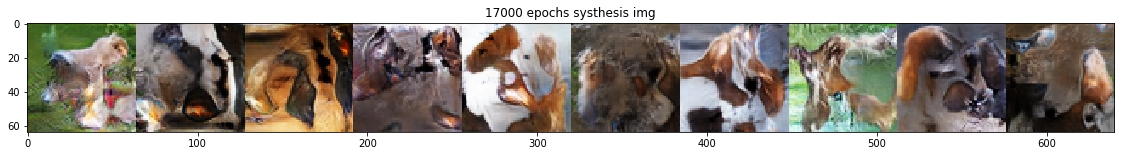

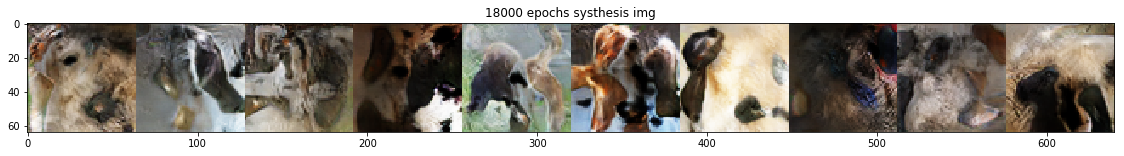

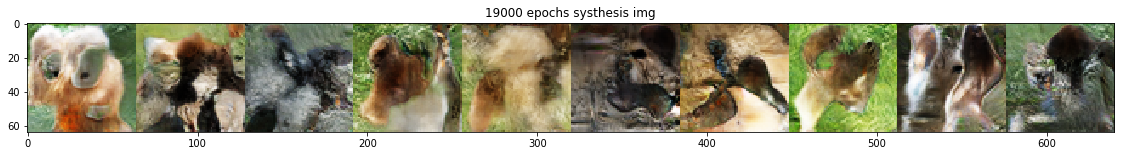

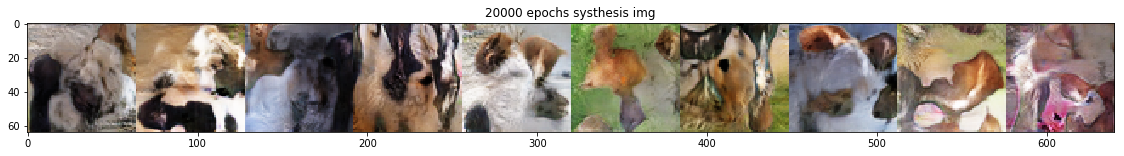

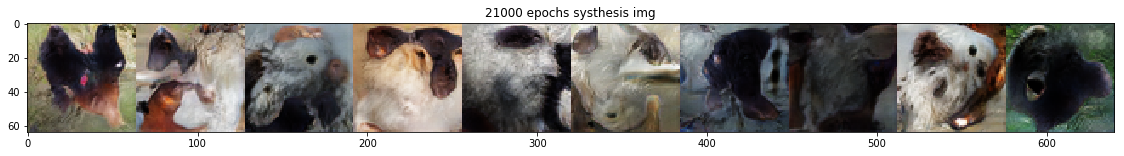

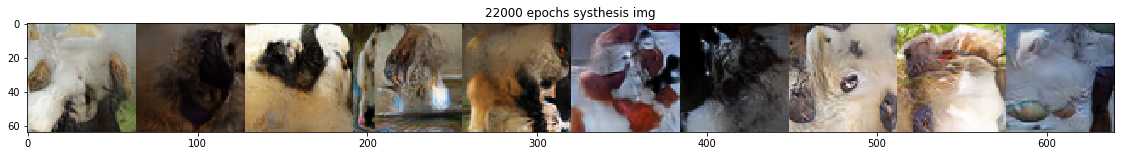

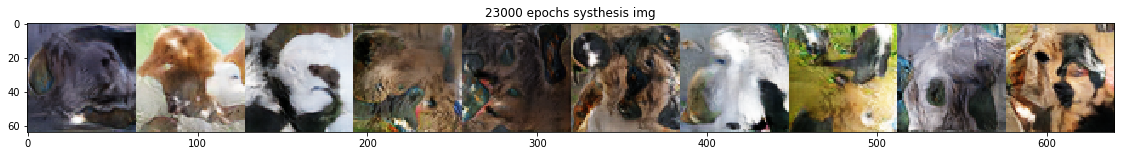

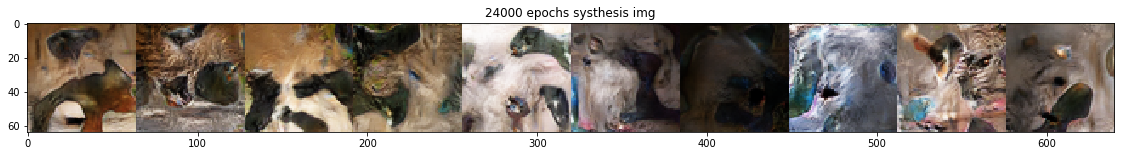

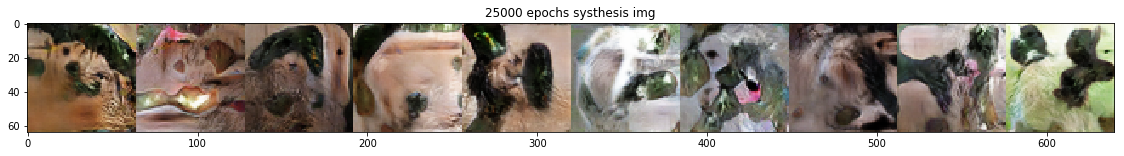

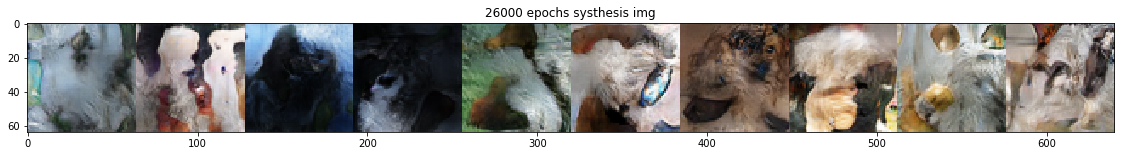

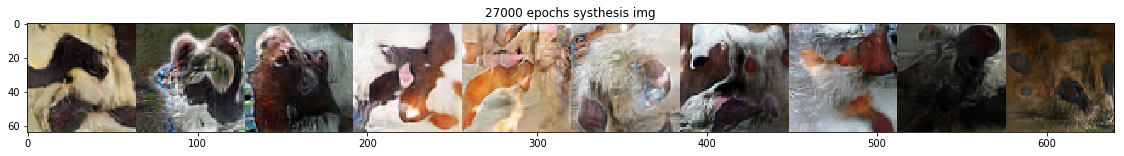

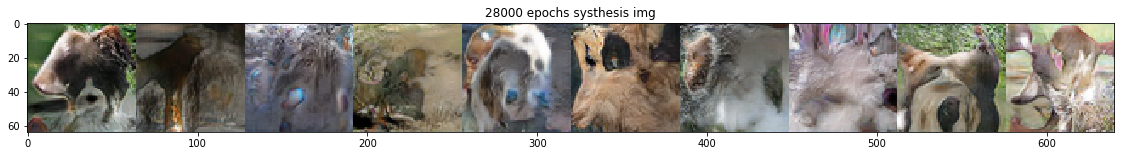

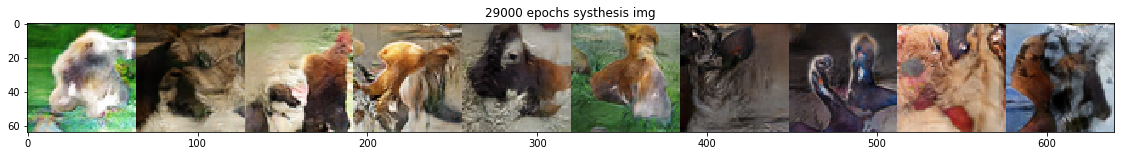

In [10]:
import time
tStart = time.time()
tBegin = tStart
epochs = 30000
batch = 64



for times in range(epochs):
    # =======================
    # ==train discriminater==
    # =======================
    noise = np.random.normal(0,1,(batch,100))
    synthesis_img = Generator.predict(noise)
    fake_label = np.zeros(batch)
    d_loss_f = Discriminator.train_on_batch(synthesis_img,fake_label)
    
    random = np.random.randint(0,idxIn-batch)
    sub_images = imagesIn[random:random+batch]
    real_label = np.ones(batch)
    d_loss_r = Discriminator.train_on_batch(sub_images,real_label)
    
    # =======================
    # ====train generator====
    # =======================
    noise = np.random.normal(0,1,(batch,100))
    noise_target = np.ones(len(noise))
    g_loss = GAN.train_on_batch(noise,noise_target)
    
    #option to see loss
    #print ('epoch: %d, [Discriminator: d_loss: %f], [ Generator: loss: %f]' % (times, d_loss[0], g_loss[0]))
    
    if times%1000 == 0:
        tEnd = time.time()
        print ('epoch: %d, [Discriminator: d_loss_f: %f, d_loss_r: %f], [ Generator: loss: %f], Training time: %d s' 
               % (times,d_loss_f[0], d_loss_r[0], g_loss[0], tEnd-tStart))
        tStart = tEnd
        img = np.ones((64,640,3))
        noise = np.random.normal(0,1,(10,100))
        synthesis_img = Generator.predict(noise)*127.5+127.5
        #print(synthesis_img[0].min()), print(synthesis_img[0].max()), print(synthesis_img[0].dtype)
        for i in range(10):
            img[:,i*64:(i+1)*64,:]=synthesis_img[i]
        img = img.astype('int32')
        plt.figure(figsize=(20,2)),plt.imshow(img)
        plt.title('%d epochs systhesis img'%times)

tEEnd = time.time()
print('total training time: %d s' %(tEEnd-tBegin) )

In [ ]:
z = zipfile.PyZipFile('images.zip', mode='w')

for k in range(10):
    noise = np.random.normal(0,1,(1,100))
    generated_image = Generator.predict(noise)
    f = str(k)+'.png'
    generated_image = (generated_image*127.5+127.5).astype('int8')    
    img = generated_image[0,:,:,:]
    img = Image.fromarray(img, 'RGB')
    plt.imshow(img)
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()

In [12]:
GAN.save('DOG_GAN_v1.h5')
Generator.save('Generator_v1.h5')
Discriminator.save('Discriminator_v1.h5')